# Hate Speech Classification

Hate speech is defined by the Cambridge Dictionary as 'public speech that expresses hate or encourages violence toward a person or group based on something such as race, religion, sex, or sexual orientation'

Steps to classify hate speech:
- Preprocess the text data
- Convert text to numerical tokens
- Build and Train ML
- Test the Model
- Save and use it later

## Requirements

In [ ]:
!pip install spacy
!pip install git+https://github.com/troyhunterz/preprocess_tr.git
!pip install np_utils
!pip install mlxtend

## Libraries

In [165]:
import preprocess_tr as ps 
import numpy as np
import pandas as pd
import re
from mlxtend.plotting import plot_confusion_matrix
import pickle as pkl

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model

# warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data & Explore

In [166]:
df = pd.read_csv('dataset/data.csv', index_col=0)
df.head(3)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [167]:
# 0 - hate speech | 1 - offensive language | 2 - neither
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [168]:
vc = df['class'].value_counts()
index = list(vc.index)
count = min(vc.values)

count, index

(1430, [1, 2, 0])

In [169]:
df_bal = pd.DataFrame()
for i in index:
    temp = df[df['class']==i].sample(count)
    df_bal = df_bal._append(temp, ignore_index=True)

df = df_bal

In [170]:
df['class'].value_counts()

class
1    1430
2    1430
0    1430
Name: count, dtype: int64

## Data Preprocessing

In [171]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.contraction_to_expansion(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.rm_html(x)
    x = ps.remove_retweets(x)
    x = ps.rm_accented_chars(x)
    x = ps.rm_special_chars(x)
    x = re.sub('(.)\\1{2,}', '\\1', x)
    return x

In [172]:
df['tweet'] = df['tweet'].apply(lambda x: get_clean(x))
df.head(3)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,3,0,1,emd hoe
1,3,0,3,0,1,retweet elisha40hands bitch you got too many t...
2,3,0,3,0,1,clicquotsuave maas mermaid and sharkette pussy


## Token Tokenization

In [173]:
text = df['tweet'].tolist()
text[:2]

['emd hoe', 'retweet elisha40hands bitch you got too many teeth in your mouth']

In [174]:
token = Tokenizer()
token.fit_on_texts(text)

In [175]:
len(token.word_counts)

11596

In [176]:
# print(token.index_word)
# {1: 'a', 2: 'i', 3: 'the', 4: 'retweet', 5: 'you', 6: 'to', 7: 'is', 8: 'bitch' ... 

In [177]:
x = ['test text']
token.texts_to_sequences(x)

[[990, 513]]

In [178]:
vocab_size = len(token.word_counts)+1
encoded_text = token.texts_to_sequences(text)
# print(encoded_text)
# [[3779, 79, 5, 49, 52, 5, 76, 8, 957, 16, 79, 22, 7, 1, 433, 520, 2, 88, 81, 6, 3780], [4, 3781, 22, 8, 329, 6, 20, 1339, 3782] ...

In [179]:
max_lenght = 120
X = pad_sequences(encoded_text, maxlen=max_lenght, padding='post')
print(X[:1])

[[3832   48    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [180]:
X.shape

(4290, 120)

## Model Building

In [181]:
y = df['class']
y[:3]

0    1
1    1
2    1
Name: class, dtype: int64

In [182]:
y = to_categorical(df['class'])
print(y[:3])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train.shape, X_test.shape

((3432, 120), (858, 120))

In [184]:
vec_size = 300

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_lenght))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(.2))

model.add(Dense(32, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

In [185]:
model.compile(optimizer=Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4617 - loss: 1.0473 - val_accuracy: 0.8089 - val_loss: 0.5922
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8118 - loss: 0.5257 - val_accuracy: 0.8147 - val_loss: 0.4816
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8900 - loss: 0.3150 - val_accuracy: 0.8170 - val_loss: 0.4770
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9450 - loss: 0.1684 - val_accuracy: 0.7972 - val_loss: 0.5261
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9773 - loss: 0.0932 - val_accuracy: 0.7925 - val_loss: 0.6054


## Model Testing

In [186]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test[:3]

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

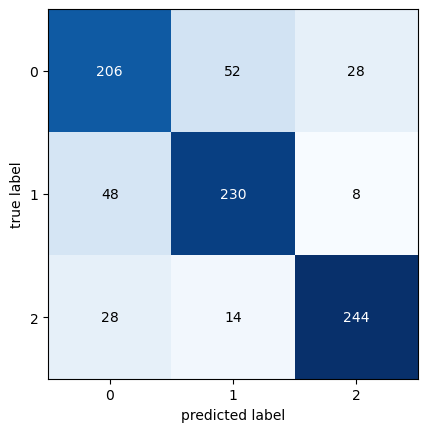

In [187]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=-1), y_pred));

In [188]:
print(classification_report(np.argmax(y_test, axis=-1), y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       286
           1       0.78      0.80      0.79       286
           2       0.87      0.85      0.86       286

    accuracy                           0.79       858
   macro avg       0.79      0.79      0.79       858
weighted avg       0.79      0.79      0.79       858



## Testing Custom Data

In [189]:
x = 'Hello, how are you?'

In [190]:
def get_encoded(x):
    x = get_clean(x)
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=max_lenght, padding='post')
    return x

In [191]:
get_encoded(x)

array([[3318,   71,   25,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [192]:
np.argmax(model.predict(get_encoded(x)), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([2], dtype=int64)

## Load Store Model

In [193]:
# keras
model.save('models/hate_speech_classification.keras')
model = load_model('models/hate_speech_classification.keras')

np.argmax(model.predict(get_encoded(x)), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([2], dtype=int64)

In [194]:
# pickle
pkl.dump(token, open('models/token.pkl', 'wb'))